In [5]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns
import pandas as pd

import scipy.stats
import datetime
import matplotlib.pyplot as plt

# create agent

In [6]:
# subset = agents(agents.x > 5)
class WealthAgent(ap.Agent):
    """ An agent that makes `transactions"""
    def setup(self):
        self.name = ''
        self.mean = 0  
        self.txns = []
        self.zscores = []
        self.shifted_zscores = []

    # TODO: each agent should probably be fed p_txn table by the model 
    # vs. currently, model feeds p_txn, and mean
    def shift_zscores(self):
        shift = self.mean * 4 # WARNING hardcoded 4
        self.shifted_zscores = np.concatenate(
            (self.zscores[-shift:] , self.zscores[:-shift]))

    def transact(self, timestep):
        p_txn = self.shifted_zscores[timestep-1]
        if np.random.random() < p_txn:
            print('transacted. timestep', timestep, 'ptxn', p_txn)
            self.txns.append(timestep)

# create model

In [19]:

class WealthModel(ap.Model):
    """ A simple model of random wealth transfers """
    def create_zscore(self):
        zscore_list = []
        # scipy norm has stddev = 1, mean of 0
        # assume all happens within 5 std devs per side of bell curve 
        max_std_devs = 5 
        steps_per_hr = int(60 / self.p.mins_per_step)
        # each side is 12 hours
        std_dev_per_step = (max_std_devs/12) / steps_per_hr 
        # Generate table of p's per step by integrating bell curve
        for step in range(int(self.p.steps/2)):
            p_txn = scipy.integrate.quad(
                            scipy.stats.norm.pdf, 
                            step * std_dev_per_step,
                            (step+1) * std_dev_per_step
                        )[0] # quad() Returns: value, error
            zscore_list.append(p_txn)
        zscores = zscore_list.copy()
        zscores = np.array(zscores)
        print('first zscore', zscores[0])
        print('last zscore', zscores[-1])
        # Center zscore at midnight (highest p_txn at midnight)
        zscores = np.append(
            zscores,
            np.flip(zscores))
        if False: # For debugging, can set p_txn to 1 to always transact
            zscores[0] = 1
            zscores[-1] = 1
            zscores[1:-1] = 0
        print('num zscores', len(zscores))#, 'zscores', zscores)
        print('- '*10)
        return zscores

    def setup(self):
        # WARNING: is setting avg num txns = 3 appropriate? probably not
        self.avg_num_txns = 3 # arbitrarily defined
        self.zscores = self.create_zscore()
        self.zscores = self.avg_num_txns * self.zscores 
        # self.p for parameters

        # Create agents
        self.agents = ap.AgentList(self, 
            self.p.num_agents_normal + self.p.num_agents_suspicious, 
            WealthAgent) 

        # Set mean for each agent by creating int for each agent
        # TODO: refactor so select by agent type and assign same mean
        # instead of this nonsense
        names = \
            ['normal'] * self.p.num_agents_suspicious + \
            ['suspicious'] * self.p.num_agents_suspicious
        mean_txn_normal = self.p.mean_txn_hrs['normal']
        mean_txn_suspicious = self.p.mean_txn_hrs['suspicious']
        means = \
            [mean_txn_normal] * self.p.num_agents_normal + \
            [mean_txn_suspicious] * self.p.num_agents_suspicious
        self.agents.mean = ap.AttrIter(means)
        self.agents.name= ap.AttrIter(names)
        # Same p_txn table (centered at midnight) for all agents
        self.agents.zscores = self.zscores 

        # now that we've set the means 
        # we can update the p_txn table for each agent
        for agent in self.agents:
            agent.shift_zscores() 
            print('mean', agent.mean)
            #print('zscore', agent.shifted_zscores)

    def step(self):
        """ Define the models' events per simulation step. """
        self.agents.transact(self.t)

    def update(self):
        """ Record variables after setup and each step. """
        #self.record('txn or not', self.txn, self.txn_time)
        total_txns = 0
        for agent in self.agents:
            total_txns += len(agent.txns)
        self.record('num txns (across all agents)', total_txns)

    def end(self):
        self.agents.record('txns')  # must be attribute

In [20]:
MEAN_TXN_HRS = {'normal':14, 
                'suspicious':22}
MINS_PER_STEP = 15

parameters = {
    'num_agents_normal':10000,
    'num_agents_suspicious':10,
    'mean_txn_hrs':MEAN_TXN_HRS,
    'seed': 42,
    'mins_per_step' : MINS_PER_STEP, # 1 hr
    'steps': 24 * (60/MINS_PER_STEP), # 24 hours * steps per hr
}


# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

# run model

In [21]:
model = WealthModel(parameters)
results = model.run()

first zscore 0.041481456911556636
last zscore 2.0279846144161732e-07
num zscores 96
- - - - - - - - - - 
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14
mean 14

# analyze results

In [22]:
all_txns = []
all_agents = []

for agent in model.agents:
    print(agent.id, 'with txns: ',  agent.txns)
    for timestamp in agent.txns:
        print( timestep_to_time(timestamp).strftime(
            '%H:%M')
        )
        all_agents.append(agent.id)
        all_txns.append(timestep_to_time(timestamp))
        #all_types.append(agetn)
all_txns = pd.DataFrame(
    zip(all_agents, all_txns), columns=['agent_id', 'txn_time'])
#all_txns
#all_txns.dtypes

1 with txns:  [56]
14:00
2 with txns:  [45, 53, 55, 58, 72]
11:15
13:15
13:45
14:30
18:00
3 with txns:  [40, 48, 52, 69]
10:00
12:00
13:00
17:15
4 with txns:  [51, 52, 59, 76]
12:45
13:00
14:45
19:00
5 with txns:  [55, 56, 61, 68]
13:45
14:00
15:15
17:00
6 with txns:  [84]
21:00
7 with txns:  [46, 50, 54, 55, 57, 60]
11:30
12:30
13:30
13:45
14:15
15:00
8 with txns:  [46, 52, 58, 61, 62, 63, 71]
11:30
13:00
14:30
15:15
15:30
15:45
17:45
9 with txns:  [56, 60, 65]
14:00
15:00
16:15
10 with txns:  [56, 58, 60, 81]
14:00
14:30
15:00
20:15
11 with txns:  [42, 47, 57]
10:30
11:45
14:15
12 with txns:  [42, 43, 46]
10:30
10:45
11:30
13 with txns:  [42, 50, 60]
10:30
12:30
15:00
14 with txns:  [35, 39, 70]
08:45
09:45
17:30
15 with txns:  []
16 with txns:  [46, 59, 61]
11:30
14:45
15:15
17 with txns:  [45, 59, 73]
11:15
14:45
18:15
18 with txns:  [34, 48, 54, 56, 66, 73]
08:30
12:00
13:30
14:00
16:30
18:15
19 with txns:  [40, 60]
10:00
15:00
20 with txns:  [38, 57, 60]
09:30
14:15
15:00
21 with

In [24]:
all_txns.index = all_txns.txn_time
resampled = all_txns.txn_time.resample('15Min')#.count().plot()
resampled.count()

#resampled = all_txns.txn_time.resample('1H')#.count().plot()
df = pd.DataFrame(resampled.count())
df.columns=['value']
df['labels'] = pd.to_datetime(df.index).strftime('%H:%M')


# plot

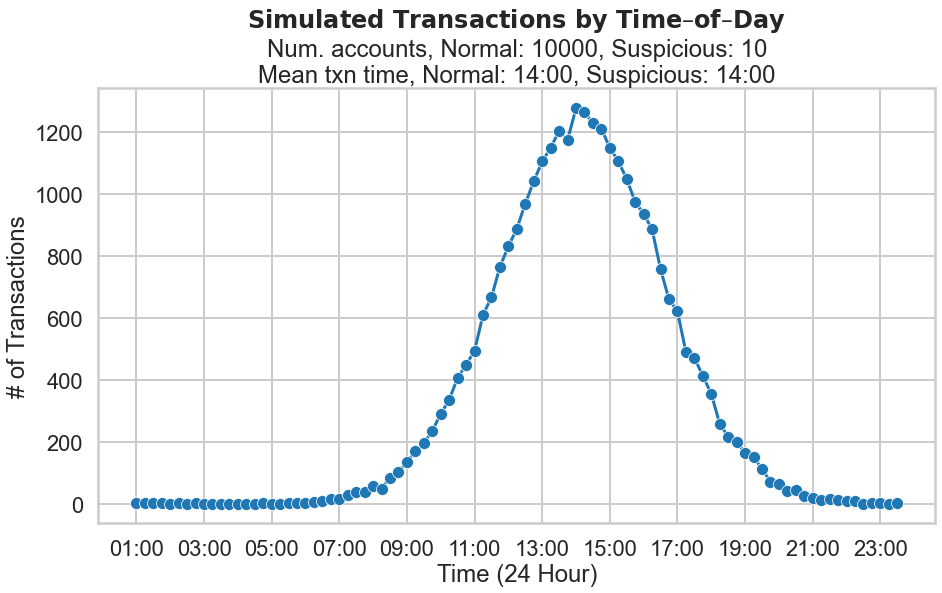

In [29]:
#left = datetime.date(2022, 10, 30)
#right = datetime.date(2022, 11, 1)
# 4pm and 10pm
#timerange = pd.date_range(start='10/30/2022 12:00', end='11/01/2022 12:00', freq='15Min')
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(x='txn_time', y='value', data=df, ax=ax,
    markers=True,  marker='o')
sns.set_style('whitegrid')
sns.set_context('poster')
ax.set(xlabel='Time (24 Hour)', ylabel='# of Transactions',
title=r"$\bf{Simulated\ Transactions\ by\ Time–of–Day}$" 
    f"\nNum. accounts, Normal: {parameters['num_agents_normal']}, "
    f"Suspicious: {parameters['num_agents_suspicious']}\n"
    f"Mean txn time, Normal: {parameters['mean_txn_hrs']['normal']}:00,"
    f" Suspicious: {parameters['mean_txn_hrs']['normal']}:00"
    )
#barp.set_xbound(left, right)
# change axes?
#display(df.labels)
#ax.set_xticks(df['txn_time'])
#ax.xaxis.set_major_locator(plt.MaxNLocator(len(df.labels)))
#ax.set(xticklabels=df['labels'])
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))